# Gaussian process system model for towing Kite

In this Jupyter Notebook we train the GP system model for the towing kite.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as RBF_sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV, gp_minimize
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from gp_tools import GPPredictModel
import gp_tools

from casadi import *

In [5]:
%matplotlib notebook

# Load data and pre-process data

- We load the previously created training data (100 sequences of MPC controlled towing kite)
- In post processing, we retrieve the following sequences from the ``do_mpc.data.Data`` object:
    - states
    - inputs
    - tether force
    - kite height
- We filter out sequences that did not converge (some inital conditions were poorly chosen) based on critera ``T_f > 1e6``.
- We filter out sequences with very large or very small values of ``w_ref`` and ``E_0``.


This is done in exactly the same way for the NN.

# Load data

In [2]:
%%capture

plans = []

names = ['kite_sampling_01']

dh_list = []
res = []
for name in names:
    load_name = '../sampling/{name}/{name}_plan.pkl'.format(name=name)
    plan = do_mpc.tools.load_pickle(load_name)
    
    dh = do_mpc.sampling.DataHandler(plan)
    dh.set_param(data_dir = '../sampling/{}/sample_results/'.format(name))

    dh.set_post_processing('input', lambda data: data['_u'])
    dh.set_post_processing('states', lambda data: data['_x'])
    dh.set_post_processing('wind', lambda data: data['_p'])
    dh.set_post_processing('T_F', lambda data: data['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data['_x'].shape[0])
    dh_list.extend(dh)
    res.extend(dh.filter(input_filter = lambda w_ref, E_0: np.abs(w_ref-10)<2 and np.abs(E_0-6)<2,
                        output_filter = lambda T_F: np.sum(T_F)/1e6>20))
    


In [3]:
print(f'After filtering we still have {len(res)} / 100 sequences.')

After filtering we still have 38 / 100 sequences.


We plot some of the remaining sequences to visually inspect the training data:

<IPython.core.display.Javascript object>


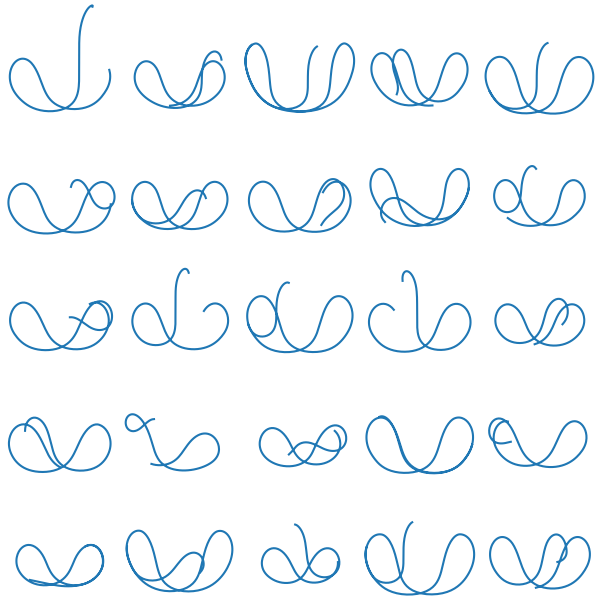

In [6]:
n_res = min(len(res),25)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(6,6))
for i, res_i in enumerate(res[:n_res]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0])
    ax[i//n_col, np.mod(i,n_col)].axis('off')

    
fig.tight_layout(pad=0)

## Create training, test and validation data

For testing purposes, we set aside a fixed number of sequences that are not using for training.

With the remaining sequences we prepare our input and output data for the neural network.
This data is then randomly partitioned into (10%) validation and (90%) training data.

In [7]:
nn_in = []
nn_out = []

n_test = 20
train_val_res = res[:-n_test]
test_res = res[-n_test:]


for i, res_i in enumerate(train_val_res):
    x_now = res_i['states'][:,:] # omit position as state

    nn_in.append(np.concatenate((res_i['input'], res_i['wind'], x_now),axis=1)[:-1,:])


    x_next = np.roll(res_i['states'],-1,axis=0)[:,:]
    dx = x_next - x_now

    nn_out.append(np.concatenate((res_i['T_F'], res_i['height'], dx),axis=1)[:-1,:])

n_traj = len(res)
    
    

    
nn_in = np.concatenate(nn_in)
nn_out = np.concatenate(nn_out)

nn_in_train, nn_in_test, nn_out_train, nn_out_test = train_test_split(nn_in, nn_out, test_size=0.1, random_state=42)

In [8]:
in_scaler = preprocessing.StandardScaler().fit(nn_in_train)
out_scaler = preprocessing.StandardScaler().fit(nn_out_train)

nn_in_train_scaled = in_scaler.transform(nn_in_train)
nn_out_train_scaled = out_scaler.transform(nn_out_train)

nn_in_test_scaled = in_scaler.transform(nn_in_test)
nn_out_test_scaled = out_scaler.transform(nn_out_test)


print(f'We have m = {nn_in_train_scaled.shape[0]} training samples')

We have m = 3223 training samples


# GP über SKLearn

We use SKlearn to train the Gaussian process. As discussed in our paper, it is not feasible to consider all $m=3223$ training samples. Instead we select a subset (100 or 200), which is randomly drawn from the full training set.

In [10]:
%%capture

np.random.seed(99)
n_samples_gpr = 200
sample_ind = np.random.choice(np.arange(nn_in_train_scaled.shape[0]),n_samples_gpr)

X_grp = nn_in_train_scaled[sample_ind,:]
Y_grp = nn_out_train_scaled[sample_ind,:]

X_test = nn_in_test_scaled
Y_test = nn_out_test_scaled

alpha = 1e-10
gpr = GaussianProcessRegressor(kernel=RBF_sklearn(length_scale=0.1), alpha = alpha, random_state=0).fit(X_grp, Y_grp)

print(f'R2 score: {gpr.score(X_test, Y_test)}')

# We obtain the lenght scale from the optimized GP for our own reimplementation with CasADi.
l = gpr.kernel_.length_scale

## Open-loop predictions

Compute an open-loop prediction for one of the test cases. Choose the case with ``case = ...``.
The open-loop predictions are computed through the class ``GPPredictModel``.

In [11]:
case = 0

x0 = (test_res[case]['states'][0]).reshape(-1,1)

pm = GPPredictModel(gpr, in_scaler, out_scaler, x0)

for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm.make_step(u0,p)

<IPython.core.display.Javascript object>


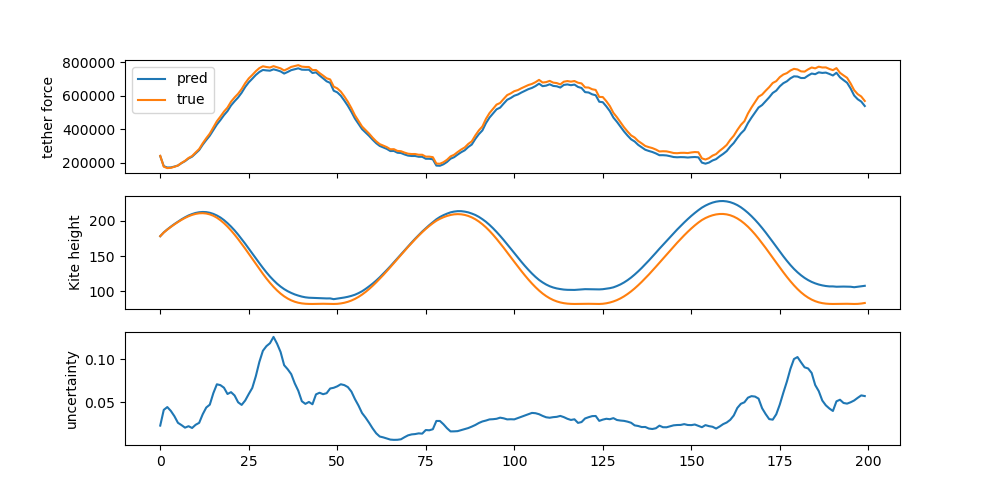

Text(0, 0.5, 'uncertainty')

In [12]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,5))

ax[0].plot(pm.aux[:,0],label='pred')
ax[0].plot(test_res[case]['T_F'], label='true')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm.aux[:,1])
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm.v)
ax[2].set_ylabel('uncertainty')

Compute open-loop predictions for all test cases:

In [13]:
gp_traj = []
gp_trust = []
n_eval = min(20,len(test_res))

for i, res_i in enumerate(test_res[:n_eval]):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm = GPPredictModel(gpr, in_scaler, out_scaler, x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm.make_step(u0,p)
    
    gp_traj.append(pm.x)
    gp_trust.append(pm.v)

Plot all test cases ($\phi$, $\theta$ diagram) and flag points with trust violations.

<IPython.core.display.Javascript object>


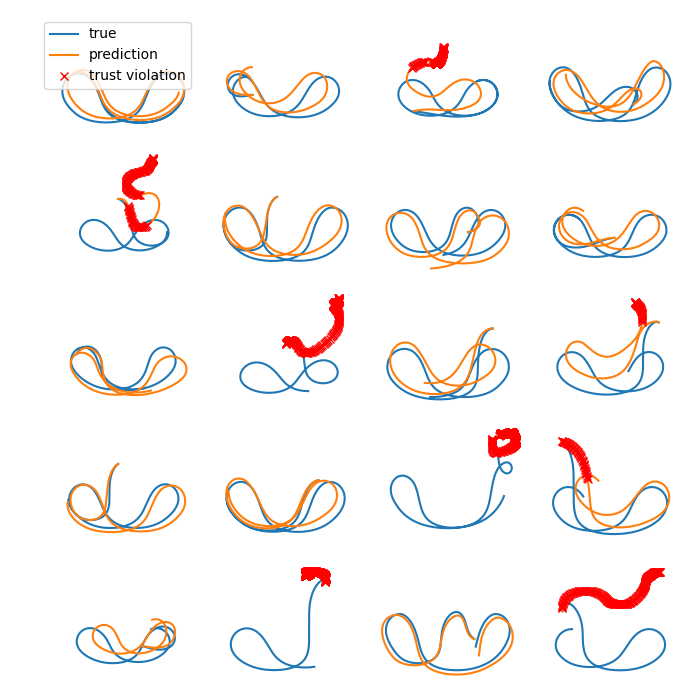

In [14]:
n_row = int(np.ceil(np.sqrt(n_eval)))
n_col = int(np.ceil(n_eval/n_row))

trust_threshold = 0.3


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(7,7))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0], label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj[i][:,1], gp_traj[i][:,0], label='prediction')
    
    viol_ind = (gp_trust[i]>= trust_threshold).flatten()
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj[i][1:,:][viol_ind,1], gp_traj[i][1:,:][viol_ind,0],
                                      'x', color='red', label='trust violation')
    
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

ax[0,0].legend()

fig.tight_layout()

## Export model

In [15]:
export_bool = False

if export_bool:
    export_name = 'S01_GP_M01_200'
    export_path = './gp_models/{}/'
    pathlib.Path(export_path.format(export_name)).mkdir(parents=True, exist_ok=True)

    export_dict = {'X_train': X_grp, 'Y_train': Y_grp, 'l': l, 'alpha': alpha,
                   'in_scaler': in_scaler, 'out_scaler': out_scaler}
    do_mpc.tools.save_pickle(export_path.format(export_name) + export_name + '_gp.pkl', export_dict)

# Execution speed sklearn vs CasADi

In [152]:
gp_cas = gp_tools.GP(gp_tools.RBF(l=l))
gp_cas.fit(X_grp, Y_grp, Sigma=alpha*np.eye(X_grp.shape[0]))

In [167]:
y_hat_cas, v_cas = gp_cas.predict(X_test[[0],:])

In [169]:
y_hat_skl, v_skl = gpr.predict(X_test[[0],:], return_cov=True)

In [170]:
v_skl-v_cas

array([[5.92533181e-07]])

In [171]:
y_hat_cas-y_hat_skl

array([[ 1.50496997e-06, -2.15794483e-06,  1.76275486e-06,
        -2.34776861e-06, -1.60690546e-06]])

In [173]:
x = SX.sym('x',1,6)
y_hat_cas, v_cas = gp_cas.predict(x)

f = Function('f', [x], [y_hat_cas, v_cas])

In [175]:
%%timeit
f(X_test[[0],:])

108 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [176]:
%%timeit
gpr.predict(X_test[[0],:], return_cov=True)

127 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
